(minipy)=
# Parser and Interpreter for minipy

We present and implement the symbolic execution techniques presented in this book for a statically typed, imperative,
proper subset of the Python language which we call *minipy*. The language supports Booleans, Integers, and (possibly
nested) tuples of Integers, first-order function definitions, assignments, and the statement types `pass`, `if`,
`while`, `try`-`except`, and `break` and `continue`. Examples of unsupported Python features are classes and objects,
strings, floats, nested function definitions and lambdas, comprehensions and generators, `for` loops, and the `raise`
statement. minipy comes with some standard builtin functions like `len`.

For example, the following is a valid minipy program:[^while_else]

In [1]:
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while i < len(haystack):
        if haystack[i] == needle:
            break
        else:
            i = i + 1
            continue
    else:
        return -1
    
    return i

t = (1, 2, 3, 4, )
x = find(3, t)
y = find(5, t)

Let us inspect the results of this computation:[^print_strings]

In [2]:
print(f"x = {x}")
print(f"y = {y}")

x = 2
y = -1


The type annotations like `: int` for function arguments and `-> int` for return types of functions, which are optional
in Python (and not checked by the standard interpreter) are required in minipy. Since furthermore, it is not possible
to declare variables without assignments, minipy is statically typed. We also forbid assignments of non-matching types
to previously assigned variables, which is entirely possible in Python. This is to simplify the presentation of our
symbolic analyses.

Since minipy does not support classes and objects, `except` clauses are restricted to `except ExceptionType` without an `as` clause:

In [3]:
def div(x: int, y: int) -> int:
    try:
        return x // y
    except ArithmeticError:
        return -1

In the following, we define a parser and interpreter for minipy. While we could also use the Python interpreter, since minipy is a subset of Python, we define our own one to be able to easily extend it later with additional features. Furthermore, we will define symbolic and concolic interpreters based on the basic interpreter defined in this section.

## Parser

Our parser is a Packrat parser {cite}`ford-02` for a [Parsing Expression Grammar (PEG)](https://en.wikipedia.org/wiki/Parsing_expression_grammar) of minipy. For both the parser and interpreter, we use definitions from the [Fuzzing Book](https://www.fuzzingbook.org/). The grammar itself is inspired by the [official Python 3 reference grammar](https://docs.python.org/3/reference/grammar.html).

In [4]:
import string
from fuzzingbook.Grammars import srange

In [5]:
MINIPY_GRAMMAR = {
    "<start>": ["<stmts>"],
    "<stmts>": ["<stmt><NEWLINE><stmts>", "<stmt>"],
    "<stmt>": ["<compound_stmt>", "<simple_stmt>"],
    "<simple_stmt>": [
        "pass",
        "break",
        "continue",
        "<return_stmt>",
        "<assert_stmt>",
        "<assignment>",
    ],
    "<compound_stmt>": [
        "<function_def>",
        "<try_stmt>",
        "<if_stmt>",
        "<while_stmt>"
    ],
    "<assignment>": ["<NAME> = <expression>"],
    "<return_stmt>": ["return <expression>"],
    "<assert_stmt>": ["assert <expression>"],
    "<if_stmt>": ["if <expression>:<block><maybe_else_block>"],
    "<maybe_else_block>": ["<NEWLINE>else:<block>", ""],
    "<while_stmt>": ["while <expression>:<block><maybe_else_block>"],
    "<try_stmt>": ["try:<block><except_block>"],

    "<function_def>": ["def <NAME>(<params>) -> <type>:<block>"],

    "<except_block>": [
        "<NEWLINE>except <NAME>:<block>",
        "<NEWLINE>except:<block>"],
    "<block>": ["<NEWLINE><INDENT><stmts><DEDENT>"],

    "<params>": ["<param>, <params>", "<param>", ""],
    "<param>": ["<NAME>: <type>"],

    "<type>": ["int", "bool", "tuple"],

    "<expression>": ["<conjunction><or_conjunctions>"],
    "<or_conjunctions>": ["<or_conjunction><or_conjunctions>", ""],
    "<or_conjunction>": [" or <conjunction>"],
    "<conjunction>": ["<inversion><and_inversions>"],
    "<and_inversions>": ["<and_inversion><and_inversions>", ""],
    "<and_inversion>": [" and <inversion>"],
    "<inversion>": ["not <inversion>", "<comparison>", "(<expression>)"],
    "<comparison>": ["<sum><maybe_compare>"],
    "<maybe_compare>": [" <compare_op> <sum>", ""],
    "<compare_op>": ["==", "!=", "<=", ">=", "<", ">"],
    "<sum>": ["<term> <ssym> <sum>", "<term>"],
    "<ssym>": ["+", "-"],
    "<term>": [
        "<factor> <tsym> <term>",
        "<factor> <tsym> (<sum>)",
        "(<sum>) <tsym> <factor>",
        "(<sum>) <tsym> (<sum>)",

        "<factor>",
    ],
    "<tsym>": ["*", "//", "%"],
    "<factor>": ["+<factor>", "-<factor>", "<primary>"],
    "<primary>": [
        "<atom>[<expression>]",
        "<NAME>(<args>)[<expression>]",
        "<NAME>(<args>)",
        "<atom>"
    ],
    "<args>": ["<expression>, <args>", "<expression>", ""],
    "<atom>": ["True", "False", "<tuple>", "<NAME>", "<NUMBER>"],
    "<tuple>": ["(<expression>, <expression_list>)"],
    "<expression_list>": ["<expression>, <expression_list>", ""],

    "<NEWLINE>": ["\n"],
    "<NUMBER>": ["<DIGIT><NUMBER>", "<DIGIT>"],
    "<DIGIT>": srange(string.digits),
    "<NAME>": ["<INIT_CHAR><IDCHARS>"],
    "<INIT_CHAR>": srange(string.ascii_letters + "_"),
    "<IDCHARS>": ["<IDCHAR><IDCHARS>", "<IDCHAR>", ""],
    "<IDCHAR>": srange(string.ascii_letters + string.digits + "_"),
}

To keep the grammar simple, it is quite restrictive with respect to whitespace. For example, no empty lines between statements are allowed, and tuple definitions must adhere to the form `(1, 2, 3, )` (including the final `,` and space).

The interpretation of the `<INDENT>` and `<DEDENT>` nonterminals is such that they increase / decrease the indentation level; `<INDENT>` matches for additional spaces, `<DEDENT>` matches the empty string. To account for these special nonterminals, we slightly extended the PEG parser from the Fuzzing Book.

In [6]:
from functools import lru_cache
from fuzzingbook.Parser import PEGParser

In [7]:
class PythonPEGParser(PEGParser):
    INDENT_SIZE = 4

    def __init__(self, grammar, **kwargs):
        super().__init__(grammar, **kwargs)
        self.indent = 0

    def unify_rule(self, rule, text, at):
        if self.log:
            print('unify_rule: %s with %s' % (repr(rule), repr(text[at:])))
        results = []
        for token in rule:
            at, res = self.unify_key(token, text, self.indent, at)
            if res is None:
                return at, None
            results.append(res)
        return at, results

    @lru_cache(maxsize=None)
    def unify_key(self, key, text, indent, at=0):
        # NOTE: Passing indent as a parameter is necessary for sound caching.
        if key == "<INDENT>":
            new_indent = (indent + 1) * PythonPEGParser.INDENT_SIZE
            if text[at:].startswith("".ljust(new_indent)):
                self.indent += 1
                if self.log:
                    print(f"Increasing indent to {new_indent} spaces.")
                return at + new_indent, ("".ljust(new_indent), [])
            else:
                return at, None

        if key == "<DEDENT>":
            new_indent = (indent - 1) * PythonPEGParser.INDENT_SIZE
            self.indent -= 1
            if self.log:
                print(f"Decreasing indent to {new_indent} spaces.")
            return at, ("", [])

        if self.indent > 0 and len(text) > at - 1 and text[at - 1] == "\n":
            if text[at:].startswith("".ljust(self.indent * PythonPEGParser.INDENT_SIZE)):
                at += self.indent * PythonPEGParser.INDENT_SIZE
            else:
                return at, None

        if key not in self.cgrammar:
            if text[at:].startswith(key):
                return at + len(key), (key, [])
            else:
                return at, None
        for rule in self.cgrammar[key]:
            to, res = self.unify_rule(rule, text, at)
            if res is not None:
                return to, (key, res)

        return 0, None

Running the parser produces a parse tree:

In [8]:
from fuzzingbook.GrammarFuzzer import display_tree
import graphviz

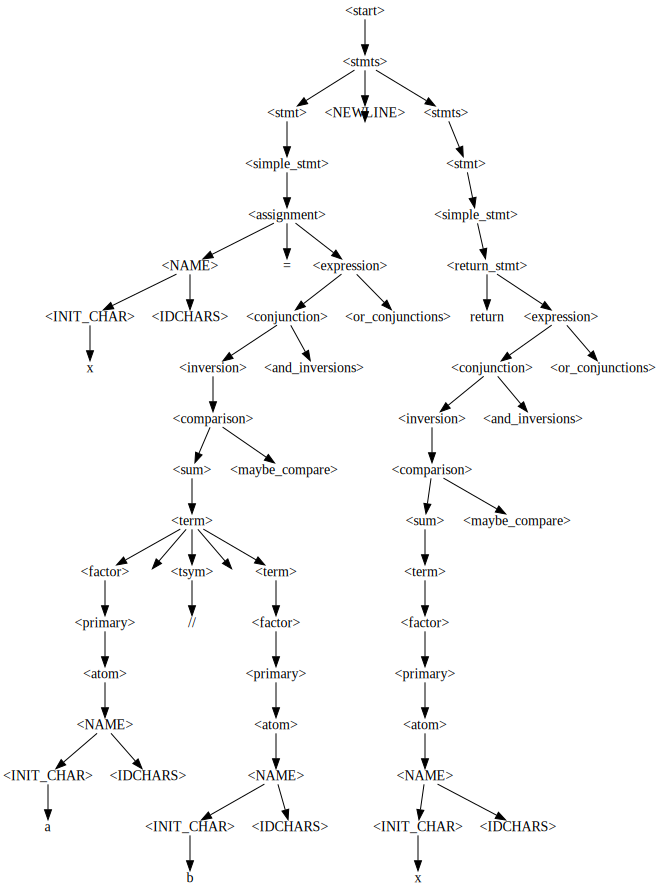

In [9]:
example_program = """x = a // b
return x"""
parser = PythonPEGParser(MINIPY_GRAMMAR)
tree = parser.parse(example_program)[0]
display_tree(tree)

One problem with our minipy grammar is that it is quite restrictive when it comes to whitespace. For instance, it is not allowed to add empty lines between statements. Also comments are unsupported. Instead of making the grammar more complex, we use a simple helper function to remove comments and whitespace from raw text:

In [10]:
def strip_comments_and_whitespace(inp: str) -> str:
    lines = []

    for line in inp.split("\n"):
        comment_start = line.find("#")
        if comment_start > -1:
            line = line[:comment_start]

        line = line.rstrip()
        if not line.strip():  # Generally must not remove leading whitespace, but here we check for empty lines
            continue

        lines.append(line)

    return "\n".join(lines)

In [11]:
example_program = """x = a // b  # A division statement
# An empty line:

return x # Now we return"""

print(example_program)

x = a // b  # A division statement
# An empty line:

return x # Now we return


In [12]:
from fuzzingbook.ExpectError import ExpectError

In [13]:
with ExpectError():
    tree = parser.parse(example_program)[0]
    display_tree(tree)

Traceback (most recent call last):
  File "/tmp/ipykernel_991/3620741631.py", line 2, in <module>
    tree = parser.parse(example_program)[0]
  File "/opt/conda/lib/python3.9/site-packages/fuzzingbook/Parser.py", line 503, in parse
    raise SyntaxError("at " + repr(text[cursor:]))
SyntaxError: at '  # A division statement\n# An empty line:\n\nreturn x # Now we return' (expected)


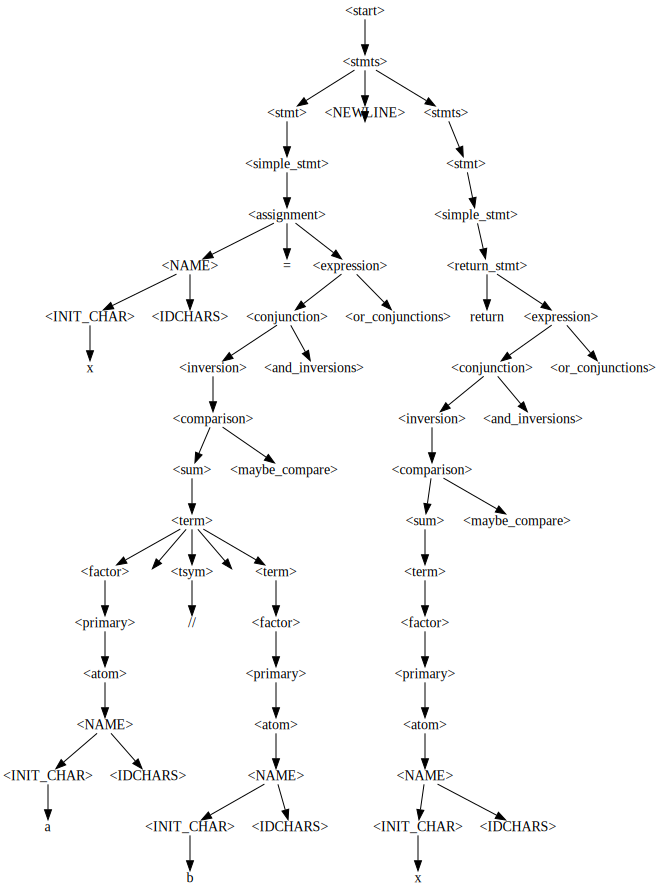

In [14]:
tree = parser.parse(strip_comments_and_whitespace(example_program))[0]
display_tree(tree)

For not having to deal with raw parse trees as output by the generic packrat parser, we translate these into an abstract syntax tree (AST) with specialized classes for each language concept. Our base class is `ASTNode`:

In [15]:
import json
from typing import Union, List, Tuple, Callable

In [16]:
ParseTree = Tuple[str, List['ParseTree']]

In [17]:
class ASTNode:
    def __init__(self, code: str):
        self.code = code

    def to_str_dict(self):
        return (
                {"<type>": type(self).__name__} |
                {
                    str(var):
                        value if isinstance(value, int) or isinstance(value, str) else
                        [child.to_str_dict() for child in value] if isinstance(value, list) else
                        "None" if value is None
                        else value.to_str_dict()
                    for var, value in vars(self).items()
                }
        )
    
    def transform(self, transformer: Callable[['ASTNode'], 'ASTNode']) -> 'ASTNode':
        raise NotImplementedError()

    def __repr__(self):
        return json.dumps(self.to_str_dict(), indent=2)

The method `transform`, following the Visitor pattern, can be used for AST transformations (we use this, for example, in {ref}`techniques:transparent_function_execution`).

The specific AST class for an `if` statement looks as follows: 

```python
class IfStmt(ASTNode):
    def __init__(
            self,
            guard: 'Expression',
            then_block: Block,
            else_block: Optional[Block] = None):
        super().__init__(
            f"if {guard.code}:\n{indent(then_block.code, '    ')}" +
            ("" if not else_block else f"\nelse:\n{indent(else_block.code, '    ')}"))
        self.guard = guard
        self.then_block = then_block
        self.else_block = else_block

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(IfStmt(
            self.guard.transform(transformer),
            self.then_block.transform(transformer),
            None if self.else_block is None else self.else_block.transform(transformer)))
```

To inspect the complete definitions for all AST node classes, press the toggle on the right below.

In [18]:
from typing import Optional


def indent(inp: str, by: str) -> str:
    lines = inp.split("\n")
    return "\n".join([by + line for line in lines])


class ASTNode:
    def __init__(self, code: str):
        self.code = code

    def to_str_dict(self):
        return (
                {"<type>": type(self).__name__} |
                {
                    str(var):
                        value if isinstance(value, int) or isinstance(value, str) else
                        [child.to_str_dict() for child in value] if isinstance(value, list) else
                        "None" if value is None
                        else value.to_str_dict()
                    for var, value in vars(self).items()
                }
        )

    def transform(self, transformer: Callable[['ASTNode'], 'ASTNode']) -> 'ASTNode':
        raise NotImplementedError()

    def __repr__(self):
        return json.dumps(self.to_str_dict(), indent=2)


class Stmts(ASTNode):
    def __init__(self, stmts: List[ASTNode]):
        stmts_ = []
        for stmt in stmts:
            if isinstance(stmt, Stmts):
                stmt: Stmts
                stmts_.extend(stmt.stmts)
            else:
                stmts_.append(stmt)

        super().__init__("\n".join([stmt.code for stmt in stmts_]))
        self.stmts = stmts_

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(Stmts([stmt.transform(transformer) for stmt in self.stmts]))


class Pass(ASTNode):
    def __init__(self):
        super().__init__("pass")

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(self)


class BreakNode(ASTNode):
    def __init__(self):
        super().__init__("break")

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(self)


class ContinueNode(ASTNode):
    def __init__(self):
        super().__init__("continue")

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(self)


class HaltNode(ASTNode):
    def __init__(self):
        super().__init__("halt")

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(self)


class ReturnNode(ASTNode):
    def __init__(self, expression: 'Expression'):
        super().__init__("return " + expression.code)
        self.expression = expression

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(ReturnNode(self.expression.transform(transformer)))


class Havoc(ASTNode):
    def __init__(self, variable: str):
        super().__init__("havoc " + variable)
        self.variable = variable

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(self)


class Assume(ASTNode):
    def __init__(self, expression: 'Expression'):
        super().__init__("assume " + expression.code)
        self.expression = expression

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(Assume(self.expression.transform(transformer)))


class Assert(ASTNode):
    def __init__(self, expression: 'Expression'):
        super().__init__("assert " + expression.code)
        self.expression = expression

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(Assert(self.expression.transform(transformer)))


class Assignment(ASTNode):
    def __init__(self, lhs: str, expression: 'Expression'):
        super().__init__(f"{lhs} = {expression.code}")
        self.lhs = lhs
        self.expression = expression

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(Assignment(self.lhs, self.expression.transform(transformer)))


class Block(ASTNode):
    def __init__(self, stmts: List[ASTNode]):
        super().__init__("\n".join([stmt.code for stmt in stmts]))
        self.stmts = stmts

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(Block([stmt.transform(transformer) for stmt in self.stmts]))


class FunctionDef(ASTNode):
    def __init__(self, name: str, params: List['Param'], t: str, block: Block):
        super().__init__(
            f"def {name}(" + ", ".join([param.code for param in params]) +
            f") -> {t}:\n{indent(block.code, '    ')}")
        self.name = name
        self.params = params
        self.t = t
        self.block = block

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(FunctionDef(
            self.name, [param.transform(transformer) for param in self.params],
            self.t, self.block.transform(transformer)))


class Param(ASTNode):
    def __init__(self, name: str, type: str):
        super().__init__(f"{name}: {type}")
        self.name = name
        self.type = type

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(self)


class TryStmt(ASTNode):
    def __init__(self, block: Block, except_block: Block,
                 exc_type: Optional[str] = None):
        super().__init__(f"try:")
        self.block = block
        self.exc_type = exc_type
        self.except_block = except_block

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(TryStmt(
            self.block.transform(transformer), self.except_block.transform(transformer), self.exc_type))


class MethodFrame(ASTNode):
    def __init__(self, result: 'NameAtom', block: Block):
        super().__init__(f"method-frame(result={result.name}):\n{indent(block.code, '    ')}")
        self.result = result
        self.block = block

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(MethodFrame(self.result.transform(transformer), self.block.transform(transformer)))


class IfStmt(ASTNode):
    def __init__(
            self,
            guard: 'Expression',
            then_block: Block,
            else_block: Optional[Block] = None):
        super().__init__(
            f"if {guard.code}:\n{indent(then_block.code, '    ')}" +
            ("" if not else_block else f"\nelse:\n{indent(else_block.code, '    ')}"))
        self.guard = guard
        self.then_block = then_block
        self.else_block = else_block

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(IfStmt(
            self.guard.transform(transformer),
            self.then_block.transform(transformer),
            None if self.else_block is None else self.else_block.transform(transformer)))


class WhileStmt(ASTNode):
    def __init__(self, guard: 'Expression', body: Block, else_block: Optional[Block] = None):
        super().__init__(
            f"while {guard.code}:\n{indent(body.code, '    ')}" +
            ("" if not else_block else f"\nelse:\n{indent(else_block.code, '    ')}"))
        self.guard = guard
        self.body = body
        self.else_block = else_block

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(WhileStmt(
            self.guard.transform(transformer),
            self.body.transform(transformer),
            None if self.else_block is None else self.else_block.transform(transformer)))


class Expression(ASTNode):
    pass


class Inversion(Expression):
    def __init__(self, argument: Expression):
        super().__init__(f"not {argument.code}")
        self.inversion = argument

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(Inversion(self.inversion.transform(transformer)))


class Conjunction(Expression):
    def __init__(self, inversions: List[Expression]):
        super().__init__("(" + " and ".join(map(lambda i: i.code, inversions)) + ")")
        self.inversions = inversions

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(Conjunction([inversion.transform(transformer) for inversion in self.inversions]))


class Disjunction(Expression):
    def __init__(self, conjunctions: List[Expression]):
        super().__init__("(" + " or ".join(map(lambda c: c.code, conjunctions)) + ")")
        self.conjunctions = conjunctions

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(Disjunction([conjunction.transform(transformer) for conjunction in self.conjunctions]))


class Comparison(Expression):
    def __init__(self, left: Expression, op: str, right: Expression):
        super().__init__(f"({left.code} {op} {right.code})")
        self.left = left
        self.op = op
        self.right = right

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(Comparison(self.left.transform(transformer), self.op, self.right.transform(transformer)))


class Sum(Expression):
    def __init__(self, left: Expression, op: str, right: Expression):
        super().__init__(f"({left.code} {op} {right.code})")
        self.left = left
        self.op = op
        self.right = right

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(Sum(self.left.transform(transformer), self.op, self.right.transform(transformer)))


class Term(Expression):
    def __init__(self, left: Expression, op: str, right: Expression):
        super().__init__(f"({left.code} {op} {right.code})")
        self.left = left
        self.op = op
        self.right = right

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(Term(self.left.transform(transformer), self.op, self.right.transform(transformer)))


class Factor(Expression):
    def __init__(self, symb: str, factor: Expression):
        super().__init__(f"{symb}{factor.code}")
        self.symb = symb
        self.factor = factor

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(Factor(self.symb, self.factor.transform(transformer)))


class TupleAccess(Expression):
    def __init__(self, atom: Expression, expression: Expression):
        super().__init__(f"{atom.code}[{expression.code}]")
        self.atom = atom
        self.expression = expression

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(TupleAccess(self.atom.transform(transformer), self.expression.transform(transformer)))


class FunctionCall(Expression):
    def __init__(self, name: str, args: List[Expression]):
        super().__init__(f"{name}(" + ", ".join([arg.code for arg in args]) + ")")
        self.name = name
        self.args = args

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(FunctionCall(self.name, [arg.transform(transformer) for arg in self.args]))


class BooleanAtom(Expression):
    def __init__(self, value: bool):
        super().__init__(str(value))
        self.value = value

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(self)


class IntAtom(Expression):
    def __init__(self, number: int):
        super().__init__(str(number))
        self.number = number

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(self)


class NameAtom(Expression):
    def __init__(self, name: str):
        super().__init__(name)
        self.name = name

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(self)


class TupleNode(Expression):
    def __init__(self, elems: List[Expression]):
        super().__init__("(" + ", ".join([elem.code for elem in elems]) + ")")
        self.elems = elems

    def transform(self, transformer: Callable[[ASTNode], ASTNode]) -> ASTNode:
        return transformer(TupleNode([elem.transform(transformer) for elem in self.elems]))

For conveniently defining the AST converter, we define a function `match` for matching parse tree elements to a tuple of expected nonterminals. `match` will return `None` if the tree does not match the expected structure; otherwise, it returns a tuple of the same length as the input nonterminal tuple containing the instantiations of these nonterminals. Once a searched-for nonterminal has been found, `match` continues with the next path in the tree, using the `next_path` function also shown below.

In [19]:
Path = Tuple[int, ...]

In [20]:
def match(symbols: Tuple[str, ...],
          tree: ParseTree,
          path: Path = (),
          result: Tuple[ParseTree, ...] = ()) -> Optional[Tuple[ParseTree, ...]]:
    if not symbols:
        return result if next_path(path, tree) is None else None

    node, children = get_subtree(path, tree)

    if node == symbols[0] or symbols[0] == "<INDENT>" and node.isspace() and len(node) % 4 == 0:
        result += ((node, children),)

        if len(symbols) == 1:
            return result if next_path(path, tree) is None else None

        next_p = next_path(path, tree)
        if next_p is None:
            return None

        return match(symbols[1:], tree, next_p, result)
    else:
        if not children:
            next_p = next_path(path, tree)
            if next_p is None:
                return None
            return match(symbols, tree, next_p, result)
        else:
            return match(symbols, tree, path + (0,), result)

In [21]:
def next_path(path: Path, tree: ParseTree) -> Optional[Path]:
    """Returns the next path in the tree; does not proceed towards leaves!"""
    if not path:
        return None

    node, children = get_subtree(path[:-1], tree)
    if len(children) > path[-1] + 1:
        return path[:-1] + (path[-1] + 1,)
    else:
        return next_path(path[:-1], tree)

A *path* is a tuple of integers pointing to a particular subtree. Consider the following tree:

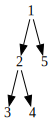

In [22]:
tree = ("1", [("2", [("3", []), ("4", [])]), ("5", [])])
display_tree(tree)

Then the path `(0, 1)` points to the subtree `("4", [])`:

In [23]:
def get_subtree(path: Path, tree: ParseTree) -> ParseTree:
    node, children = tree

    if not path:
        return tree

    return get_subtree(path[1:], children[path[0]])

In [24]:
display_tree(get_subtree((0, 1), tree))

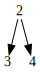

In [25]:
display_tree(get_subtree((0,), tree))

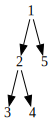

In [26]:
display_tree(get_subtree((), tree))

Let's try out the `match` function.

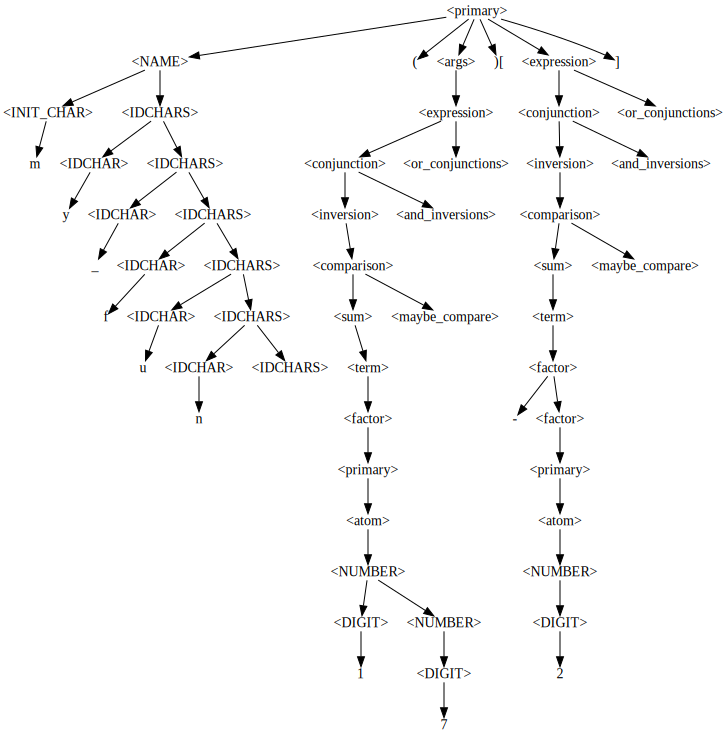

In [27]:
inp = "my_fun(17)[-2]"
parser = PythonPEGParser(MINIPY_GRAMMAR)
tree = next(parser.parse_on(inp, "<primary>"))
display_tree(tree)

In [28]:
m_res = match(("<atom>",), tree)
m_res is None

True

In [29]:
from fuzzingbook.GrammarFuzzer import tree_to_string

In [30]:
m_res = match(("<NAME>", "(", "<args>", ")[", "<expression>", "]"), tree)
list(map(tree_to_string, m_res))

['my_fun', '(', '17', ')[', '-2', ']']

In [31]:
dict(zip(("<NAME>", "(", "<args>", ")[", "<expression>", "]"), list(map(tree_to_string, m_res))))

{'<NAME>': 'my_fun',
 '(': '(',
 '<args>': '17',
 ')[': ')[',
 '<expression>': '-2',
 ']': ']'}

The class `ASTConverter` uses the match function to dissect parse trees. For example, here is the code processing a `return` statement:

```python
class ASTConverter:
    # ...
    
    def transform_return_stmt(self, stmt: ParseTree) -> ASTNode:
        m_res = match(("return ", "<expression>"), stmt)
        assert m_res is not None
        eval_expr_result = self.transform_expression(m_res[1])
        return ReturnNode(eval_expr_result)
    
    # ...
```

The top-level functions are `transform_top` for statements and `transform_expr_top` for expressions. They look up the nonterminal type of a parse tree node in a dictionary mapping these to specific transformations:

```python
class ASTConverter:
    def __init__(self):
        self.stmt_interpretations: Dict[str, Callable[[ParseTree], ASTNode]] = {
            "<start>": self.transform_start,
            "<stmts>": self.transform_stmts,
            "<stmt>": self.transform_stmt,
            "<simple_stmt>": self.transform_simple_stmt,
            "<compound_stmt>": self.transform_compound_stmt,
            "pass": self.transform_pass,
            # ...
        }

        self.expr_interpretations: Dict[str, Callable[[ParseTree], Expression]] = {
            "<expression>": self.transform_expression,
            "<conjunction>": self.transform_conjunction,
            "<inversion>": self.transform_inversion,
            # ...
        }

    def transform_top(self, stmt: ParseTree) -> ASTNode:
        node, _ = stmt
        if node in self.stmt_interpretations:
            return self.stmt_interpretations[node](stmt)

        assert False
            
    def transform_expr_top(self, expr: ParseTree) -> Expression:
        node, _ = expr
        if node in self.expr_interpretations:
            return self.expr_interpretations[node](expr)

        assert False
    
    # ...
```

The full code for the `ASTConverter` class is given below (click the toggle).

In [32]:
class ASTConverter:
    def __init__(self):
        self.stmt_interpretations: Dict[str, Callable[[ParseTree], ASTNode]] = {
            "<start>": self.transform_start,
            "<stmts>": self.transform_stmts,
            "<stmt>": self.transform_stmt,
            "<simple_stmt>": self.transform_simple_stmt,
            "<compound_stmt>": self.transform_compound_stmt,
            "pass": self.transform_pass,
            "break": self.transform_break,
            "continue": self.transform_continue,
            "halt": self.transform_halt,
            "<return_stmt>": self.transform_return_stmt,
            "<assert_stmt>": self.transform_assert_stmt,
            "<assignment>": self.transform_assignment,
            "<function_def>": self.transform_function_def,
            "<try_stmt>": self.transform_try_stmt,
            "<while_stmt>": self.transform_while_stmt,
            "<if_stmt>": self.transform_if_stmt,
            "<expression>": self.transform_expression,
        }

        self.expr_interpretations: Dict[str, Callable[[ParseTree], Expression]] = {
            "<expression>": self.transform_expression,
            "<conjunction>": self.transform_conjunction,
            "<inversion>": self.transform_inversion,
            "<comparison>": self.transform_comparison,
            "<sum>": self.transform_sum,
            "<term>": self.transform_term,
            "<factor>": self.transform_factor,
            "<primary>": self.transform_primary,
            "<atom>": self.transform_atom,
            "<tuple>": self.transform_tuple,
        }

    def transform_top(self, stmt: ParseTree) -> ASTNode:
        node, _ = stmt
        if node in self.stmt_interpretations:
            return self.stmt_interpretations[node](stmt)

        assert False

    def transform_expr_top(self, expr: ParseTree) -> Expression:
        node, _ = expr
        if node in self.expr_interpretations:
            return self.expr_interpretations[node](expr)

        assert False

    def transform_sequence(self, stmts: Tuple[ParseTree, ...]) -> List[ASTNode]:
        return [self.transform_top(stmt) for stmt in stmts]

    def transform_simple_redirect(self, stmt: ParseTree, options: Tuple[str, ...]) -> ASTNode:
        for option in options:
            if m_res := match((option,), stmt):
                return self.transform_top(m_res[0])

        assert False

    def transform_start(self, stmt: ParseTree) -> ASTNode:
        m_res = match(("<stmts>",), stmt)
        assert m_res is not None
        return self.transform_top(m_res[0])

    def transform_stmts(self, stmt: ParseTree) -> Stmts:
        if m_res := match(("<stmt>", "<NEWLINE>", "<stmts>"), stmt):
            return Stmts(self.transform_sequence((m_res[0], m_res[2])))

        m_res = match(("<stmt>",), stmt)
        assert m_res is not None
        return Stmts([self.transform_top(m_res[0])])

    def transform_stmt(self, stmt: ParseTree) -> ASTNode:
        return self.transform_simple_redirect(stmt, ("<compound_stmt>", "<simple_stmt>"))

    def transform_simple_stmt(self, stmt: ParseTree) -> ASTNode:
        return self.transform_simple_redirect(
            stmt, ("pass", "break", "continue", "halt", "<return_stmt>",
                   "<assert_stmt>", "<assignment>", "<expression>"))

    def transform_compound_stmt(self, stmt: ParseTree) -> ASTNode:
        return self.transform_simple_redirect(
            stmt, ("<function_def>", "<try_stmt>", "<if_stmt>", "<while_stmt>"))

    def transform_pass(self, stmt: ParseTree) -> ASTNode:
        return Pass()

    def transform_break(self, stmt: ParseTree) -> ASTNode:
        return BreakNode()

    def transform_continue(self, stmt: ParseTree) -> ASTNode:
        return ContinueNode()

    def transform_halt(self, stmt: ParseTree) -> ASTNode:
        return HaltNode()

    def transform_return_stmt(self, stmt: ParseTree) -> ASTNode:
        m_res = match(("return ", "<expression>"), stmt)
        assert m_res is not None
        eval_expr_result = self.transform_expression(m_res[1])
        return ReturnNode(eval_expr_result)

    def transform_assert_stmt(self, stmt: ParseTree) -> ASTNode:
        m_res = match(("assert ", "<expression>"), stmt)
        assert m_res is not None
        eval_expr_result = self.transform_expression(m_res[1])
        return Assert(eval_expr_result)

    def transform_assignment(self, stmt: ParseTree) -> ASTNode:
        m_res = match(("<NAME>", " = ", "<expression>",), stmt)
        assert m_res is not None
        eval_expr_result = self.transform_expr_top(m_res[2])
        return Assignment(tree_to_string(m_res[0]), eval_expr_result)

    def transform_function_def(self, stmt: ParseTree) -> FunctionDef:
        m_res = match(("def ", "<NAME>", "(", "<params>", ") -> ", "<type>", ":", "<block>",), stmt)
        assert m_res is not None

        f_name = tree_to_string(m_res[1])
        params = self.transform_params(m_res[3])
        t = tree_to_string(m_res[5])
        block = self.transform_block(m_res[-1])

        return FunctionDef(f_name, params, t, block)

    def transform_param(self, param: ParseTree) -> Param:
        m_res = match(("<NAME>", ": ", "<type>",), param)
        assert m_res is not None
        return Param(tree_to_string(m_res[0]), tree_to_string(m_res[-1]))

    def transform_params(self, params: ParseTree) -> List[Param]:
        result: List[Param] = []

        if m_res := match(("<param>", ", ", "<params>"), params):
            result.append(self.transform_param(m_res[0]))
            result.extend(self.transform_params(m_res[-1]))
        elif m_res := match(("<param>",), params):
            result.append(self.transform_param(m_res[0]))
        elif tree_to_string(params) == "":
            pass

        return result

    def transform_try_stmt(self, stmt: ParseTree) -> TryStmt:
        m_res = match(("try:", "<block>", "<except_block>"), stmt)
        assert m_res is not None

        block = self.transform_block(m_res[1])
        if sub_m_res := match(("<NEWLINE>", "except ", "<NAME>", ":", "<block>"), stmt):
            except_block = self.transform_block(sub_m_res[-1])
            return TryStmt(block, except_block, tree_to_string(sub_m_res[2]))
        elif match(("<NEWLINE>", "except:", "<block>"), stmt):
            except_block = self.transform_block(sub_m_res[-1])
            return TryStmt(block, except_block, tree_to_string(sub_m_res[2]))

        assert False
        
    def transform_if_stmt(self, stmt: ParseTree) -> IfStmt:
        m_res = match(("if ", "<expression>", ":", "<block>", "<maybe_else_block>"), stmt)
        assert m_res is not None

        eval_expr_result = self.transform_expr_top(m_res[1])

        sub_m_res = match(("<NEWLINE>", "else:", "<block>"), m_res[-1])
        if sub_m_res:
            else_block = self.transform_block(sub_m_res[-1])
            return IfStmt(eval_expr_result, self.transform_block(m_res[3]), else_block)
        else:
            return IfStmt(eval_expr_result, self.transform_block(m_res[3]))

    def transform_while_stmt(self, stmt: ParseTree) -> WhileStmt:
        m_res = match(("while ", "<expression>", ":", "<block>", "<maybe_else_block>"), stmt)
        assert m_res is not None

        guard = self.transform_expression(m_res[1])
        body = self.transform_block(m_res[-2])

        sub_m_res = match(("<NEWLINE>", "else:", "<block>"), m_res[-1])
        if sub_m_res is None:
            return WhileStmt(guard, body)
        else:
            else_block = self.transform_block(sub_m_res[-1])
            return WhileStmt(guard, body, else_block)

    def transform_block(self, stmt: ParseTree) -> Block:
        if m_res := match(("<NEWLINE>", '<INDENT>', "<stmts>"), stmt):
            return Block(self.transform_stmts(m_res[-1]).stmts)
        elif m_res := match(("<simple_stmt>",), stmt):
            return Block([self.transform_simple_stmt(m_res[0])])

        assert False

    def transform_expression(self, expr: ParseTree) -> Expression:
        m_res = match(("<conjunction>", "<or_conjunctions>"), expr)
        assert m_res is not None

        conj_eval = self.transform_conjunction(m_res[0])

        if tree_to_string(m_res[1]) == "":
            return conj_eval

        result = [conj_eval]
        remaining_tree = m_res[1]

        while True:
            m_res = match((" or ", "<conjunction>", "<or_conjunctions>"), remaining_tree)
            if m_res is None:
                assert tree_to_string(remaining_tree) == ""
                break

            result.append(self.transform_conjunction(m_res[1]))
            remaining_tree = m_res[2]

        return Disjunction(result)

    def transform_conjunction(self, expr: ParseTree) -> Expression:
        m_res = match(("<inversion>", "<and_inversions>"), expr)
        assert m_res is not None

        inv_eval = self.transform_inversion(m_res[0])

        if tree_to_string(m_res[1]) == "":
            return inv_eval

        result = [inv_eval]
        remaining_tree = m_res[1]

        while True:
            m_res = match((" and ", "<inversion>", "<and_inversions>"), remaining_tree)
            if m_res is None:
                assert tree_to_string(remaining_tree) == ""
                break

            result.append(self.transform_inversion(m_res[1]))
            remaining_tree = m_res[2]

        return Conjunction(result)

    def transform_inversion(self, expr: ParseTree) -> Expression:
        if m_res := match(("not ", "<inversion>"), expr):
            return Inversion(self.transform_inversion(m_res[1]))
        elif m_res := match(("<comparison>",), expr):
            return self.transform_comparison(m_res[0])
        elif m_res := match(("(", "<expression>", ")"), expr):
            return self.transform_expression(m_res[1])

        assert False

    def transform_comparison(self, expr: ParseTree) -> Expression:
        m_res = match(("<sum>", "<maybe_compare>"), expr)
        assert m_res is not None

        eval_sum_result = self.transform_sum(m_res[0])
        sub_m_res = match((" ", "<compare_op>", " ", "<sum>"), m_res[1])
        if sub_m_res is None:
            assert tree_to_string(m_res[1]) == ""
            return eval_sum_result

        eval_sum_2_result = self.transform_sum(sub_m_res[3])

        return Comparison(eval_sum_result, tree_to_string(sub_m_res[1]), eval_sum_2_result)

    def transform_sum(self, expr: ParseTree) -> Expression:
        if m_res := match(("<term>", " ", "<ssym>", " ", "<sum>"), expr):
            eval_res_1 = self.transform_term(m_res[0])
            eval_res_2 = self.transform_sum(m_res[4])

            return Sum(eval_res_1, tree_to_string(m_res[2]), eval_res_2)
        elif m_res := match(("<term>",), expr):
            return self.transform_term(m_res[0])

        assert False

    def transform_term(self, expr: ParseTree) -> Expression:
        if m_res := match(("<factor>", " ", "<tsym>", " ", "<term>"), expr):
            eval_res_1 = self.transform_factor(m_res[0])
            eval_res_2 = self.transform_term(m_res[-1])
            return Term(eval_res_1, tree_to_string(m_res[2]), eval_res_2)
        elif m_res := match(("<factor>", " ", "<tsym>", " (", "<sum>", ")"), expr):
            eval_res_1 = self.transform_factor(m_res[0])
            eval_res_2 = self.transform_sum(m_res[-2])
            return Term(eval_res_1, tree_to_string(m_res[2]), eval_res_2)
        elif m_res := match(("(", "<sum>", ") ", "<tsym>", " ", "<factor>"), expr):
            eval_res_1 = self.transform_sum(m_res[1])
            eval_res_2 = self.transform_factor(m_res[-1])
            return Term(eval_res_1, tree_to_string(m_res[3]), eval_res_2)
        elif m_res := match(("(", "<sum>", ") ", "<tsym>", " (", "<sum>", ")"), expr):
            eval_res_1 = self.transform_sum(m_res[1])
            eval_res_2 = self.transform_sum(m_res[-2])
            return Term(eval_res_1, tree_to_string(m_res[3]), eval_res_2)
        elif m_res := match(("<factor>",), expr):
            return self.transform_factor(m_res[0])

        assert False

    def transform_factor(self, expr: ParseTree) -> Expression:
        if m_res := match(("+", "<factor>"), expr):
            return Factor("+", self.transform_factor(m_res[1]))
        elif m_res := match(("-", "<factor>"), expr):
            return Factor("-", self.transform_factor(m_res[1]))
        elif m_res := match(("<primary>",), expr):
            return self.transform_primary(m_res[0])

        assert False

    def transform_primary(self, expr: ParseTree) -> Expression:
        if m_res := match(("<atom>", "[", "<expression>", "]"), expr):
            eval_atom_res = self.transform_atom(m_res[0])
            eval_expr_res = self.transform_expression(m_res[2])

            return TupleAccess(eval_atom_res, eval_expr_res)
        elif m_res := match(("<NAME>", "(", "<args>", ")[", "<expression>", "]"), expr):
            eval_args_res = self.transform_args(m_res[2])
            eval_expr_res = self.transform_expression(m_res[-2])

            return TupleAccess(FunctionCall(tree_to_string(m_res[0]), eval_args_res), eval_expr_res)
        elif m_res := match(("<NAME>", "(", "<args>", ")"), expr):
            eval_args_res = self.transform_args(m_res[2])
            return FunctionCall(tree_to_string(m_res[0]), eval_args_res)
        elif m_res := match(("<atom>",), expr):
            return self.transform_atom(m_res[0])

        assert False

    def transform_args(self, expr: ParseTree) -> List[Expression]:
        result: List[Expression] = []

        if m_res := match(("<expression>", ", ", "<args>"), expr):
            result.append(self.transform_expression(m_res[0]))
            result.extend(self.transform_args(m_res[-1]))
        elif m_res := match(("<expression>",), expr):
            result.append(self.transform_expression(m_res[0]))
        elif tree_to_string(expr) == "":
            pass

        return result

    def transform_atom(self, expr: ParseTree) -> Expression:
        atom_str = tree_to_string(expr)

        if m_res := match(("<tuple>",), expr):
            return self.transform_tuple(m_res[0])
        elif match(("True",), expr):
            return BooleanAtom(True)
        elif match(("False",), expr):
            return BooleanAtom(False)
        elif match(("<NUMBER>",), expr):
            return IntAtom(int(atom_str))
        elif match(("<NAME>",), expr):
            return NameAtom(atom_str)

        assert False

    def transform_tuple(self, expr: ParseTree) -> Expression:
        if tree_to_string(expr) == "()":
            return TupleNode([])

        m_res = match(("(", "<expression>", ", ", "<expression_list>", ")"), expr)
        assert m_res is not None
        expr_eval = self.transform_expression(m_res[1])

        if tree_to_string(m_res[-2]) == "":
            return TupleNode([expr_eval])

        result = [expr_eval]
        remaining_tree = m_res[-2]

        while True:
            m_res = match(("<expression>", ", ", "<expression_list>"), remaining_tree)
            if m_res is None:
                assert tree_to_string(remaining_tree) == ""
                break

            result.append(self.transform_expression(m_res[0]))
            remaining_tree = m_res[2]

        return TupleNode(result)

We define some convenience functions for parsing a string into a statement or expression, optionally starting form a specific nonterminal.

In [33]:
def parse(inp: str) -> ASTNode:
    inp = strip_comments_and_whitespace(inp)
    tree = PythonPEGParser(MINIPY_GRAMMAR).parse(inp)[0]
    return ASTConverter().transform_top(tree)


def parse_on(inp: str, nonterminal: str) -> ASTNode:
    inp = strip_comments_and_whitespace(inp)
    tree = next(PythonPEGParser(MINIPY_GRAMMAR).parse_on(inp, nonterminal))
    return ASTConverter().transform_top(tree)


def parse_expr(inp: str) -> Expression:
    inp = strip_comments_and_whitespace(inp)
    tree = next(PythonPEGParser(MINIPY_GRAMMAR).parse_on(inp, "<expression>"))
    return ASTConverter().transform_expr_top(tree)


def parse_expr_on(inp: str, nonterminal: str) -> Expression:
    inp = strip_comments_and_whitespace(inp)
    tree = next(PythonPEGParser(MINIPY_GRAMMAR).parse_on(inp, nonterminal))
    return ASTConverter().transform_expr_top(tree)

In [34]:
ast = parse(example_program)
print(f"AST: {ast}\n")
print(f"Code:\n{ast.code}\n")
print(f"LHS of assignment: {ast.stmts[0].lhs}")

AST: {
  "<type>": "Stmts",
  "code": "x = (a // b)\nreturn x",
  "stmts": [
    {
      "<type>": "Assignment",
      "code": "x = (a // b)",
      "lhs": "x",
      "expression": {
        "<type>": "Term",
        "code": "(a // b)",
        "left": {
          "<type>": "NameAtom",
          "code": "a",
          "name": "a"
        },
        "op": "//",
        "right": {
          "<type>": "NameAtom",
          "code": "b",
          "name": "b"
        }
      }
    },
    {
      "<type>": "ReturnNode",
      "code": "return x",
      "expression": {
        "<type>": "NameAtom",
        "code": "x",
        "name": "x"
      }
    }
  ]
}

Code:
x = (a // b)
return x

LHS of assignment: x


Subsequently, we define an interpreter for processing minipy parse trees.

## Interpreter

```{admonition} TODO
Refer to the Python language specification.
```

The Python type `ValueType` is the union type of all types to which minipy expressions can evaluate.

In [35]:
from typing import Tuple, Union

In [36]:
NestedIntTuple = Tuple[Union[int, 'NestedIntTuple'], ...]
ValueType = Union[int, bool, NestedIntTuple]

We also need syntactical types for minipy.

In [37]:
class Type:
    def __init__(self, name: str):
        self.name = name

    def __eq__(self, other):
        return type(self) == type(other) and self.name == other.name

    def __hash__(self):
        return hash(self.name)

    def __repr__(self):
        return f"Type({repr(self.name)})"

    def __str__(self):
        return self.name

In [38]:
INT_TYPE = Type("int")
BOOL_TYPE = Type("bool")
TUPLE_TYPE = Type("tuple")

The function `get_type` returns a syntactical type either for the type name or a value of the type.

In [39]:
def get_type(expr: Union[str, ValueType]) -> Type:
    if type(expr) is str:
        return INT_TYPE if expr == "int" else (TUPLE_TYPE if expr == "tuple" else "bool")
    elif type(expr) is int:
        return INT_TYPE
    elif type(expr) is bool:
        return BOOL_TYPE
    elif type(expr) is tuple:
        return TUPLE_TYPE

    assert False

Next, we define the classes for variables, *stores* and *environments*. A variable has a name and a type. An store is a mapping from variables to values. Environments encapsulate a store and a repository of defined functions. Environments are used to evaluate expressions, and are updated by executing statements (note that minipy expressions are side-effect free, apart from the fact that their evaluation may raise exceptions).

In [40]:
class Variable:
    def __init__(self, name: str, type: Type):
        self.name = name
        self.type = type

    def __eq__(self, other):
        return isinstance(other, Variable) and self.name == other.name and self.type == other.type

    def __hash__(self):
        return hash((self.name, self.type))

    def __repr__(self):
        return f"Variable({repr(self.name)}, {repr(self.type)})"

    def __str__(self):
        return self.name

In [41]:
from typing import Dict
import copy

In [42]:
class Store:
    def __init__(self, env: Optional[Dict[Variable, ValueType]] = None):
        self.env: Dict[Variable, ValueType] = {} if env is None else copy.deepcopy(env)

    def copy(self):
        return Store(self.env)

    def has_var(self, variable: Union[str, Variable]) -> bool:
        if isinstance(variable, Variable):
            return variable in self.env
        else:
            return self.get_variable(variable) is not None

    def get_variable(self, name: str) -> Optional[Variable]:
        maybe_var = [variable for variable in self.env if variable.name == name]
        assert len(maybe_var) <= 1
        return None if not maybe_var else maybe_var[0]

    def __getitem__(self, item):
        if isinstance(item, Variable) and item in self.env:
            return self.env[item]
        else:
            assert type(item) is str
            maybe_var = self.get_variable(item)
            if maybe_var is not None:
                return self.env[maybe_var]

            raise AttributeError(f"Attempt to read uninitialized variable {item}")

    def __setitem__(self, key, value):
        assert isinstance(key, Variable)
        maybe_var = self.get_variable(key.name)
        if maybe_var is not None:
            existing_type = maybe_var.type
            if existing_type != key.type:
                raise RuntimeError(f"Incompatible assignment types for variable {key.name}: "
                                   f"{key.type}, previously: {existing_type}")

        self.env[key] = value

    def __eq__(self, other):
        return isinstance(other, type(self)) and self.env == other.env

    def __str__(self):
        return "{" + ", ".join([str(var) + ": " + str(val) for var, val in self.env.items()]) + "}"

    def __repr__(self):
        return f"Store({repr(self.env)})"

In [43]:
store = Store()
store[Variable("x", INT_TYPE)] = 42
store["x"]

42

In [44]:
with ExpectError():
    store["a"]

Traceback (most recent call last):
  File "/tmp/ipykernel_991/3540991285.py", line 2, in <module>
    store["a"]
  File "/tmp/ipykernel_991/3609531971.py", line 28, in __getitem__
    raise AttributeError(f"Attempt to read uninitialized variable {item}")
AttributeError: Attempt to read uninitialized variable a (expected)


In [45]:
store[Variable("x", INT_TYPE)] = 17
store["x"]

17

In [46]:
with ExpectError():
    store[Variable("x", BOOL_TYPE)] = False

Traceback (most recent call last):
  File "/tmp/ipykernel_991/3534397449.py", line 2, in <module>
    store[Variable("x", BOOL_TYPE)] = False
  File "/tmp/ipykernel_991/3609531971.py", line 36, in __setitem__
    raise RuntimeError(f"Incompatible assignment types for variable {key.name}: "
RuntimeError: Incompatible assignment types for variable x: bool, previously: int (expected)


In [47]:
from typing import Callable

In [48]:
class Environment:
    def __init__(self,
                 store: Optional[Store] = None,
                 functions: Optional[Dict[str, Tuple[Tuple[Variable], Type, Callable]]] = None):
        self.store: Store = Store() if store is None else store.copy()
        self.functions: Dict[str, Tuple[Tuple[Variable], Type, Callable]] = \
            {} if functions is None else copy.deepcopy(functions)

        self.add_default_functions()

    def add_default_functions(self):
        self.functions["len"] = ((Variable("t", TUPLE_TYPE),), INT_TYPE, len)

    def copy(self):
        return Environment(self.store, self.functions)

    def __getitem__(self, item):
        if self.store.has_var(item):
            return self.store[item]
        elif item in self.functions:
            return self.functions[item]
        else:
            raise AttributeError(f"Attempt to read uninitialized function/variable {item}")

    def __setitem__(self, key, value):
        if isinstance(key, Variable):
            if key.name in self.functions:
                del self.functions[key.name]

            self.store[key] = value
        else:
            assert isinstance(key, str)
            if self.store.has_var(key):
                del self.store.env[self.store.get_variable(key)]

            self.functions[key] = value

    def __repr__(self):
        return f"Environment({repr(self.store)}, {repr(self.functions)})"

We add the `len` function as a default (library) function into our environment. Other Python library functions than `len` and those defined in the executed code (or explicitly supplied to the `Environment` constructor) will not be supported by the interpreter. If needed, they can be registered in the `add_default_functions` function.

We are now ready to define the minipy interpreter. Its top-level functions are `execute(self, stmt: ASTNode, environment: Environment) -> None` for the execution of statements, and `evaluate(self, expr: Expression, environment: Environment) -> ValueType` for the evaluation of expressions. Both functions basically delegate to appropriate interpretation functions based on a dictionary from nonterminals to interpretations. Note that expression statements are not supported in minipy; otherwise, the `execute` function would have to call into `evaluate`.[^side_effects]

In [49]:
class Interpreter:
    def __init__(self):
        self.stmt_interpretations: Dict[typing.Type[ASTNode], Callable[[ASTNode, Environment], None]] = {}
        self.expr_interpretations: Dict[typing.Type[Expression], Callable[[ASTNode, Environment], ValueType]] = {}
            
    def execute(self, stmt: ASTNode, environment: Environment) -> None:
        t = type(stmt)
        if t in self.stmt_interpretations:
            self.stmt_interpretations[t](stmt, environment)
            return

        assert False
            
    def evaluate(self, expr: Expression, environment: Environment) -> ValueType:
        t = type(expr)
        if t in self.expr_interpretations:
            return self.expr_interpretations[t](expr, environment)

        assert False

The evaluation function for the `<sum>` nonterminal, for example, looks like follows:

```python
def evaluate_sum(self, expr: Sum, environment: Environment) -> ValueType:
    operator_map: Dict[str, Callable] = {"+": operator.add, "-": operator.sub}

    left = self.evaluate(expr.left, environment)
    right = self.evaluate(expr.right, environment)

    return operator_map[expr.op](left, right)
```

We model abrupt completion by special exception classes. For example, executing a `break` statement yields a `Break` exception object, that can be caught by the interpretation of a `while` statement.

In [50]:
class AbruptCompletionNoException(RuntimeError):
    pass


class Return(AbruptCompletionNoException):
    def __init__(self, value: ValueType):
        self.value = value


class Continue(AbruptCompletionNoException):
    pass


class Halt(AbruptCompletionNoException):
    pass


class Break(AbruptCompletionNoException):
    pass

```python
def execute_break(self, stmt: ASTNode, environment: Environment) -> None:
    raise Break()
```

The code evaluating a `while` statement, shown below, catches `break`s and `continue`s. Furthermore, it demonstrates the meta-interpreter character of our minipy interpreter: All language features of minipy are mirrored by our interpreter in full Python.

```python
def execute_while_stmt(self, stmt: WhileStmt, environment: Environment) -> None:
    eval_guard_res = self.evaluate(stmt.guard, environment)
    assert type(eval_guard_res) is bool

    while eval_guard_res:
        try:
            self.execute_block(stmt.body, environment)
        except Continue:
            eval_guard_res = self.evaluate(stmt.guard, environment)
            continue
        except Break:
            break
        eval_guard_res = self.evaluate(stmt.guard, environment)
    else:
        if stmt.else_block is not None:
            self.execute_block(stmt.else_block, environment)
            return
```

To inspect the full code of the interpreter, press the toggle on the right.

In [62]:
import operator

class Interpreter:
    def __init__(self):
        self.stmt_interpretations: Dict[typing.Type[ASTNode], Callable[[ASTNode, Environment], None]] = {
            Stmts: self.execute_stmts,
            Pass: self.execute_pass,
            BreakNode: self.execute_break,
            ContinueNode: self.execute_continue,
            ReturnNode: self.execute_return_stmt,
            Assert: self.execute_assert_stmt,
            Assignment: self.execute_assignment,
            Block: self.execute_block,
            FunctionDef: self.execute_function_def,
            TryStmt: self.execute_try_stmt,
            WhileStmt: self.execute_while_stmt,
            IfStmt: self.execute_if_stmt,
        }

        self.expr_interpretations: Dict[typing.Type[Expression], Callable[[ASTNode, Environment], ValueType]] = {
            Disjunction: self.evaluate_disjunction,
            Conjunction: self.evaluate_conjunction,
            Inversion: self.evaluate_inversion,
            Comparison: self.evaluate_comparison,
            Sum: self.evaluate_sum,
            Term: self.evaluate_term,
            Factor: self.evaluate_factor,
            TupleNode: self.evaluate_tuple,
            TupleAccess: self.evaluate_tuple_access,
            FunctionCall: self.evaluate_fun_call,
            Param: self.evaluate_param,
            BooleanAtom: self.evaluate_boolean,
            IntAtom: self.evaluate_int,
            NameAtom: self.evaluate_name,
        }

    def execute(self, stmt: ASTNode, environment: Environment) -> None:
        t = type(stmt)
        if t in self.stmt_interpretations:
            self.stmt_interpretations[t](stmt, environment)
            return

        if isinstance(stmt, Expression):
            # Expression Statements
            self.evaluate(stmt, environment)
            return

        assert False

    def execute_stmts(self, stmt: Stmts, environment: Environment) -> None:
        for sub in stmt.stmts:
            self.execute(sub, environment)

    def execute_pass(self, stmt: ASTNode, environment: Environment) -> None:
        pass

    def execute_break(self, stmt: ASTNode, environment: Environment) -> None:
        raise Break()

    def execute_continue(self, stmt: ASTNode, environment: Environment) -> None:
        raise Continue()

    def execute_return_stmt(self, stmt: ReturnNode, environment: Environment) -> None:
        eval_expr_result = self.evaluate(stmt.expression, environment)
        raise Return(eval_expr_result)

    def execute_assert_stmt(self, stmt: Assert, environment: Environment) -> None:
        eval_expr_result = self.evaluate(stmt.expression, environment)
        assert eval_expr_result

    def execute_assignment(self, stmt: Assignment, environment: Environment) -> None:
        eval_expr_result = self.evaluate(stmt.expression, environment)
        environment[Variable(stmt.lhs, get_type(eval_expr_result))] = eval_expr_result

    def execute_function_def(self, stmt: FunctionDef, environment: Environment) -> None:
        f_name = stmt.name
        ret_type = get_type(stmt.t)
        params = [self.evaluate_param(param) for param in stmt.params]

        def func(*args):
            new_env = environment.copy()
            for idx, parameter in enumerate(params):
                new_env[parameter] = args[idx]
            try:
                self.execute_block(stmt.block, new_env)
            except Return as ret:
                return ret.value

        environment[f_name] = (params, ret_type, func)

    def evaluate_param(self, param: Param) -> Variable:
        return Variable(param.name, get_type(param.type))

    def execute_try_stmt(self, stmt: TryStmt, environment: Environment) -> None:
        try:
            self.execute_block(stmt.block, environment)
        except Exception as exc:
            if issubclass(type(exc), AbruptCompletionNoException):
                raise exc

            if stmt.exc_type is not None:
                caught_exc_type = getattr(sys.modules["builtins"], stmt.exc_type)
                if issubclass(type(exc), caught_exc_type):
                    self.execute_block(stmt.except_block, environment)
                    return
            else:
                self.execute_block(stmt.except_block, environment)
                return

            assert False

    def execute_if_stmt(self, stmt: IfStmt, environment: Environment) -> None:
        eval_expr_result = self.evaluate(stmt.guard, environment)
        assert type(eval_expr_result) is bool

        if eval_expr_result:
            self.execute_block(stmt.then_block, environment)
            return
        else:
            if stmt.else_block is not None:
                self.execute_block(stmt.else_block, environment)
                return

    def execute_while_stmt(self, stmt: WhileStmt, environment: Environment) -> None:
        eval_guard_res = self.evaluate(stmt.guard, environment)
        assert type(eval_guard_res) is bool

        while eval_guard_res:
            try:
                self.execute_block(stmt.body, environment)
            except Continue:
                eval_guard_res = self.evaluate(stmt.guard, environment)
                continue
            except Break:
                break
            eval_guard_res = self.evaluate(stmt.guard, environment)
        else:
            if stmt.else_block is not None:
                self.execute_block(stmt.else_block, environment)
                return

    def execute_block(self, stmt: Block, environment: Environment) -> None:
        for a_stmt in stmt.stmts:
            self.execute(a_stmt, environment)

    def evaluate(self, expr: Expression, environment: Environment) -> ValueType:
        t = type(expr)
        if t in self.expr_interpretations:
            return self.expr_interpretations[t](expr, environment)

        assert False

    def evaluate_disjunction(self, expr: Disjunction, environment: Environment) -> ValueType:
        for sub in expr.conjunctions:
            if self.evaluate(sub, environment):
                return True
        return False

    def evaluate_conjunction(self, expr: Conjunction, environment: Environment) -> ValueType:
        for sub in expr.inversions:
            if not self.evaluate(sub, environment):
                return False
        return True

    def evaluate_inversion(self, expr: Inversion, environment: Environment) -> ValueType:
        return not self.evaluate(expr.inversion, environment)

    def evaluate_comparison(self, expr: Comparison, environment: Environment) -> ValueType:
        operator_map: Dict[str, Callable] = {
            "==": operator.eq,
            "!=": operator.ne,
            "<=": operator.le,
            ">=": operator.ge,
            "<": operator.lt,
            ">": operator.gt
        }

        left = self.evaluate(expr.left, environment)
        right = self.evaluate(expr.right, environment)

        return operator_map[expr.op](left, right)

    def evaluate_sum(self, expr: Sum, environment: Environment) -> ValueType:
        operator_map: Dict[str, Callable] = {"+": operator.add, "-": operator.sub}

        left = self.evaluate(expr.left, environment)
        right = self.evaluate(expr.right, environment)

        return operator_map[expr.op](left, right)

    def evaluate_term(self, expr: Term, environment: Environment) -> ValueType:
        operator_map: Dict[str, Callable] = {
            "*": operator.mul,
            "//": lambda a, b: a // b,
            "%": operator.mod
        }

        left = self.evaluate(expr.left, environment)
        right = self.evaluate(expr.right, environment)

        return operator_map[expr.op](left, right)

    def evaluate_factor(self, expr: Factor, environment: Environment) -> ValueType:
        eval_res = self.evaluate(expr.factor, environment)
        if expr.symb == "-":
            return -eval_res
        else:
            return eval_res

    def evaluate_fun_call(self, expr: FunctionCall, environment: Environment) -> ValueType:
        f_name = expr.name
        if f_name not in environment.functions:
            raise NameError(f"name '{f_name}' is not defined")
        args = [self.evaluate(arg, environment) for arg in expr.args]
        params, ret_type, fun = environment.functions[f_name]
        if len(args) != len(params):
            raise TypeError(f"{f_name}({', '.join(map(str, params))}) takes {len(params)} "
                            f"argument(s) but {len(args)} were given")
        fun_result = fun(*args)
        if type(fun_result).__name__ != str(ret_type):
            raise TypeError(f"Unexpected return type {type(fun_result)} for function "
                            f"'{f_name}', expected {ret_type}")
        return fun_result

    def evaluate_tuple_access(self, expr: TupleAccess, environment: Environment) -> ValueType:
        eval_atom_res = self.evaluate(expr.atom, environment)
        if type(eval_atom_res) is not tuple:
            raise TypeError(f"'{type(eval_atom_res)} is not subscriptable")
        eval_expr_res = self.evaluate(expr.expression, environment)
        if type(eval_expr_res) is not int:
            raise TypeError(f"list indices must be integers, not {type(eval_expr_res)}")

        return eval_atom_res[eval_expr_res]

    def evaluate_name(self, expr: NameAtom, environment: Environment) -> ValueType:
        return environment[expr.name]

    def evaluate_boolean(self, expr: BooleanAtom, environment: Environment) -> ValueType:
        return expr.value

    def evaluate_int(self, expr: IntAtom, environment: Environment) -> ValueType:
        return expr.number

    def evaluate_tuple(self, expr: TupleNode, environment: Environment) -> ValueType:
        return tuple([self.evaluate(sub, environment) for sub in expr.elems])

In [52]:
interpreter = Interpreter()
environment = Environment()
interpreter.evaluate(parse_expr("3 + 4 * 2"), environment)

11

In [53]:
interpreter.evaluate(parse_expr("(3 + 4) * 2"), environment)

14

In [54]:
with ExpectError():
    interpreter.evaluate(parse_expr("1 // 0"), environment)

Traceback (most recent call last):
  File "/tmp/ipykernel_991/1620470182.py", line 2, in <module>
    interpreter.evaluate(parse_expr("1 // 0"), environment)
  File "/tmp/ipykernel_991/669977194.py", line 151, in evaluate
    return self.expr_interpretations[t](expr, environment)
  File "/tmp/ipykernel_991/669977194.py", line 203, in evaluate_term
    return operator_map[expr.op](left, right)
  File "/tmp/ipykernel_991/669977194.py", line 196, in <lambda>
    "//": lambda a, b: a // b,
ZeroDivisionError: integer division or modulo by zero (expected)


Let's try something more complex: Executing our linear search method `find` from above.

In [55]:
program = """
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while i < len(haystack):
        if haystack[i] == needle:
            break
        else:
            i = i + 1
            continue
    else:
        return -1
    return i
    
t = (1, 2, 3, 4, )
x = find(3, t)
y = find(5, t)
"""

In [56]:
from IPython.display import display, Markdown

In [57]:
def display_program(program: str):
    display(Markdown(f"```python\n{program.strip()}\n```"))

In [58]:
display_program(program)

```python
def find(needle: int, haystack: tuple) -> int:
    i = 0
    while i < len(haystack):
        if haystack[i] == needle:
            break
        else:
            i = i + 1
            continue
    else:
        return -1
    return i
    
t = (1, 2, 3, 4, )
x = find(3, t)
y = find(5, t)
```

In [59]:
environment = Environment()
interpreter.execute(parse(program), environment)

In [60]:
environment["x"]

2

In [61]:
environment["y"]

-1

This seems to work!

## References

```{bibliography}
:filter: docname in docnames
```

[^while_else]: The code demonstrates that minipy does support Pythons `while`-`else` syntax: The `else` branch after a
`while` loop is entered whenever the loop completed normally (and the guard evaluated to `False`), that is, not because
of a `break`, `return`, or thrown exception.

[^print_strings]: The below code is not a minipy program, since minipy does not support strings or print statements. We clearly mark minipy code boxes throughout this book; Python boxes are not marked.

[^side_effects]: minipy expressions do not have side effects, which is why expression statements, as supported in Python, are quite pointless in our subset. Expressions can call functions, but in the absence of a heap and `global` / `nonlocal` specifiers, functions have no means to change the outer state.